<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/neelkanthrawat/GNN-exercises/tree/main/Project/autoencoder_for_MNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import datasets, transforms

import numpy as np

import matplotlib.pyplot as plt

### 1. Load the MNIST dataset

In [2]:
# Define transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),    # Convert PIL image to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the tensor with mean and standard deviation of MNIST dataset
])

# Load MNIST dataset
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 115523706.60it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41484826.65it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26996113.67it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 24114593.38it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



plotting the dataset

In [3]:
# def plot_images(images, labels, captions, rows=2, cols=4):
#     fig, axes = plt.subplots(rows, cols, figsize=(10, 5))
#     for i, ax in enumerate(axes.flat):
#         ax.imshow(images[i], cmap='gray')
#         ax.set_title(captions[i])
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Get some sample images and labels from the dataset
# sample_images = [train_dataset[i][0].squeeze().numpy() for i in range(8)]
# sample_labels = [train_dataset[i][1] for i in range(8)]
# sample_captions = [f"Label: {label}" for label in sample_labels]

# # Plot the sample images with captions
# plot_images(sample_images, sample_labels, sample_captions)

### 2. Create the Dataloaders

In [4]:
# Define the sizes for train, validation, and test sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
test_size = len(test_dataset)

In [5]:
# Split the dataset into train, validation, sets
trn_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [6]:
# Define batch size for data loaders
batch_size = 64

In [7]:
# Create data loaders for train, validation, and test sets
train_loader = DataLoader(trn_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 3. Autoencoder model

In [23]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
        self.encoder_maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.encoder_conv2 = nn.Conv2d(6, 12, kernel_size=3, stride=1, padding=1)
        self.encoder_maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.encoder_linear = nn.Linear(12* 7 * 7, 64*6)

        # Decoder layers
        self.decoder_linear = nn.Linear(64*6, 12 * 7 * 7)
        self.decoder_conv1 = nn.ConvTranspose2d(12, 6, kernel_size=3, stride=1, padding=1)
        self.decoder_upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.decoder_conv2 = nn.ConvTranspose2d(6, 1, kernel_size=3, stride=1, padding=1)
        self.decoder_upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        # self.decoder_sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        x = self.encoder_conv1(x)
        x = self.encoder_maxpool1(x)
        x = self.encoder_conv2(x)
        x = self.encoder_maxpool2(x)
        x = x.view(-1, 12 * 7 * 7)
        x = self.encoder_linear(x)

        # Decoder
        x = self.decoder_linear(x)
        x = x.view(-1, 12, 7, 7)
        x = self.decoder_conv1(x)
        x = self.decoder_upsample1(x)
        x = self.decoder_conv2(x)
        x = self.decoder_upsample2(x)
        # x = self.decoder_sigmoid(x)

        return x

In [29]:
import torch
import torch.nn as nn

class Autoencoder_simpler(nn.Module):
    def __init__(self):
        super(Autoencoder_simpler, self).__init__()

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=2, padding=1)  # Use stride 2 for downscaling
        self.encoder_conv2 = nn.Conv2d(6, 12, kernel_size=3, stride=2, padding=1)  # Use stride 2 for downscaling
        self.encoder_linear = nn.Linear(12 * 7 * 7, 64*6)

        # Decoder layers
        self.decoder_linear = nn.Linear(64*6, 12 * 7 * 7)
        self.decoder_conv1 = nn.ConvTranspose2d(12, 6, kernel_size=3, stride=2, padding=1, output_padding=1)  # Use stride 2 for upscaling
        self.decoder_conv2 = nn.ConvTranspose2d(6, 1, kernel_size=3, stride=2, padding=1, output_padding=1)  # Use stride 2 for upscaling

    def forward(self, x):
        # Encoder
        x = self.encoder_conv1(x)
        x = torch.relu(x)
        x = self.encoder_conv2(x)
        x = torch.relu(x)
        x = x.view(-1, 12 * 7 * 7)
        x = self.encoder_linear(x)

        # Decoder
        x = self.decoder_linear(x)
        x = x.view(-1, 12, 7, 7)
        x = self.decoder_conv1(x)
        x = torch.relu(x)
        x = self.decoder_conv2(x)
        x = torch.relu(x)

        return x


### training and validation function

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_and_evaluate(autoencoder, train_loader, val_loader,
                       num_epochs=10, learning_rate=1e-3, print_epoch=10, device='cuda' if torch.cuda.is_available() else 'cpu'):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

    autoencoder.to(device)  # Move model to device

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0

        # Training
        autoencoder.train()
        for images, _ in train_loader:
            images = images.to(device)  # Move data to device
            optimizer.zero_grad()
            outputs = autoencoder(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        autoencoder.eval()
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)  # Move data to device
                outputs = autoencoder(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()

        # Average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Print losses
        if (epoch + 1) % print_epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.9f}, Val Loss: {val_loss:.9f}")

    return train_losses, val_losses

In [10]:
# Specify the device you want to use
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [24]:
# instantiate the model
autoencoder=Autoencoder()

# train
train_losses, val_losses = train_and_evaluate(autoencoder,
                                              train_loader, val_loader,
                                              num_epochs=20, print_epoch=2)

Epoch [2/20], Train Loss: 0.200820841, Val Loss: 0.195769854
Epoch [4/20], Train Loss: 0.191048489, Val Loss: 0.188671375
Epoch [6/20], Train Loss: 0.188101543, Val Loss: 0.186297944
Epoch [8/20], Train Loss: 0.186799742, Val Loss: 0.185154281
Epoch [10/20], Train Loss: 0.185999149, Val Loss: 0.184242475
Epoch [12/20], Train Loss: 0.185461230, Val Loss: 0.184058018
Epoch [14/20], Train Loss: 0.185013351, Val Loss: 0.183319635
Epoch [16/20], Train Loss: 0.184691923, Val Loss: 0.183204245
Epoch [18/20], Train Loss: 0.184424670, Val Loss: 0.182942750
Epoch [20/20], Train Loss: 0.184249431, Val Loss: 0.182882431


In [30]:
# instantiate the model
autoencoder_2=Autoencoder_simpler()

# train
train_losses, val_losses = train_and_evaluate(autoencoder_2,
                                              train_loader, val_loader,
                                              num_epochs=20, print_epoch=2)

Epoch [2/20], Train Loss: 0.182094858, Val Loss: 0.176142836
Epoch [4/20], Train Loss: 0.168833712, Val Loss: 0.167850794
Epoch [6/20], Train Loss: 0.164932242, Val Loss: 0.164839121
Epoch [8/20], Train Loss: 0.162611623, Val Loss: 0.162421387
Epoch [10/20], Train Loss: 0.160965757, Val Loss: 0.161225904
Epoch [12/20], Train Loss: 0.159703324, Val Loss: 0.159889232
Epoch [14/20], Train Loss: 0.158721651, Val Loss: 0.159012000
Epoch [16/20], Train Loss: 0.157865461, Val Loss: 0.158151309
Epoch [18/20], Train Loss: 0.157125558, Val Loss: 0.157417690
Epoch [20/20], Train Loss: 0.156456248, Val Loss: 0.156787520


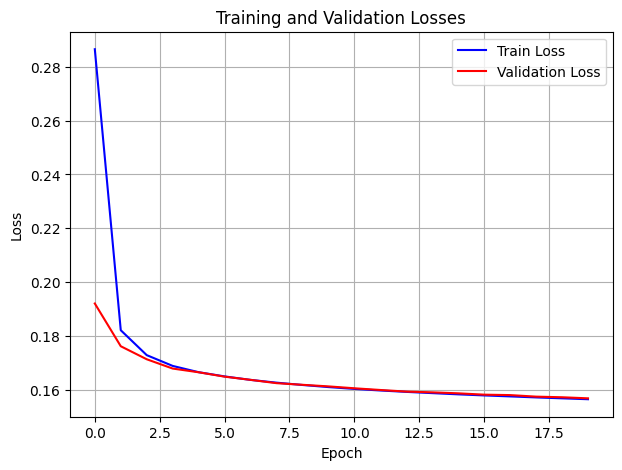

In [32]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(7, 5))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage example:
plot_losses(train_losses, val_losses)


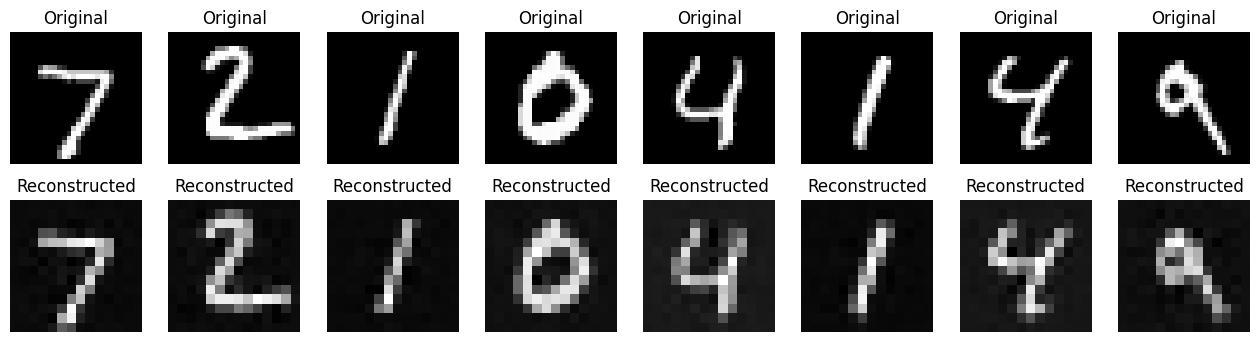

In [22]:
def test_model(autoencoder, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    autoencoder.eval()
    criterion = nn.MSELoss()

    # Get a batch of test images
    images, _ = next(iter(test_loader))
    images = images.to(device)

    # Reconstruct images using the autoencoder
    with torch.no_grad():
        reconstructed_images = autoencoder(images)

    # Move data back to CPU for plotting
    images = images.cpu()
    reconstructed_images = reconstructed_images.cpu()

    # Plot original and reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16, 4))
    for i in range(8):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.show()

# Usage example:
test_model(autoencoder, test_loader)


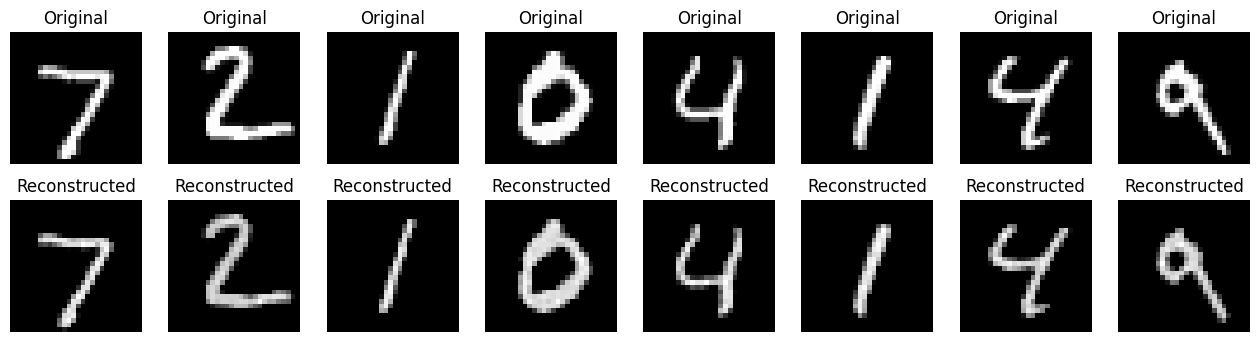

In [31]:
test_model(autoencoder_2, test_loader)

### Latest conclusion:

Simpler model (`autoencoder_2`) is better than the first model (`autoencoder_1`).

# checking something.



In [21]:
# import torch
# import torch.nn as nn
# from torchvision.datasets import MNIST
# from torch.utils.data import DataLoader
# import torchvision.transforms as transforms

# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()

#         # Encoder layers
#         self.encoder_conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
#         self.encoder_maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.encoder_conv2 = nn.Conv2d(6, 12, kernel_size=3, stride=1, padding=1)
#         self.encoder_maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.encoder_linear = nn.Linear(32 * 7 * 7, 64)

#         # Decoder layers
#         self.decoder_linear = nn.Linear(64, 32 * 7 * 7)
#         self.decoder_conv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1)
#         self.decoder_upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
#         self.decoder_conv2 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1)
#         self.decoder_upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
#         self.decoder_sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         # Encoder
#         print("image shape at the beginning:", x.shape)
#         x = self.encoder_conv1(x)
#         print("Shape after encoder_conv1:", x.shape)
#         x = self.encoder_maxpool1(x)
#         print("Shape after encoder_maxpool1:", x.shape)
#         x = self.encoder_conv2(x)
#         print("Shape after encoder_conv2:", x.shape)
#         x = self.encoder_maxpool2(x)
#         print("Shape after encoder_maxpool2:", x.shape)
#         x = x.view(-1, 32 * 7 * 7)
#         print("Shape after flattening:", x.shape)
#         x = self.encoder_linear(x)
#         print("Shape after encoder_linear:", x.shape)

#         print("encoder finished now decoder")

#         # Decoder
#         x = self.decoder_linear(x)
#         print("Shape after decoder_linear:", x.shape)
#         x = x.view(-1, 32, 7, 7)
#         print("Shape after reshaping:", x.shape)
#         x = self.decoder_conv1(x)
#         print("Shape after decoder_conv1:", x.shape)
#         x = self.decoder_upsample1(x)
#         print("Shape after decoder_upsample1:", x.shape)
#         x = self.decoder_conv2(x)
#         print("Shape after decoder_conv2:", x.shape)
#         x = self.decoder_upsample2(x)
#         print("Shape after decoder_upsample2:", x.shape)

#         return x

# # Load MNIST dataset
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# # Create an instance of the autoencoder
# autoencoder = Autoencoder()

# # Take one image from the dataset
# x, _ = next(iter(train_loader))
# image = x[0].unsqueeze(0)  # Take the first image from the batch and add a batch dimension

# # Forward pass through the autoencoder with the image
# output = autoencoder(image)


image shape at the beginning: torch.Size([1, 1, 28, 28])
Shape after encoder_conv1: torch.Size([1, 6, 28, 28])
Shape after encoder_maxpool1: torch.Size([1, 6, 14, 14])
Shape after encoder_conv2: torch.Size([1, 12, 14, 14])
Shape after encoder_maxpool2: torch.Size([1, 12, 7, 7])


RuntimeError: shape '[-1, 1568]' is invalid for input of size 588

t